<a href="https://colab.research.google.com/github/harshita23sharma/CustomerChurn/blob/main/customer_churn/notebooks/Telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import time
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/drive/MyDrive/projects/churn_prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Customers who left within the last month: Churn -> yes

In [7]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

Monthly Churn Rate = Number of Customers Who Churned in the Month / Total Number of Customers in the Month.

In [11]:
monthly_churn_rate = (df.Churn.value_counts()["Yes"] / df.shape[0])* 100
monthly_churn_rate = "{:.2f}".format(monthly_churn_rate)
print(f"Monthly Churn Rate = {monthly_churn_rate}%")

Monthly Churn Rate = 26.54%


In [12]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
df.dtypes.value_counts()

object     18
int64       2
float64     1
dtype: int64

In [16]:
df.TotalCharges.tail(5)

7038    1990.5
7039    7362.9
7040    346.45
7041     306.6
7042    6844.5
Name: TotalCharges, dtype: object

<Axes: xlabel='gender', ylabel='count'>

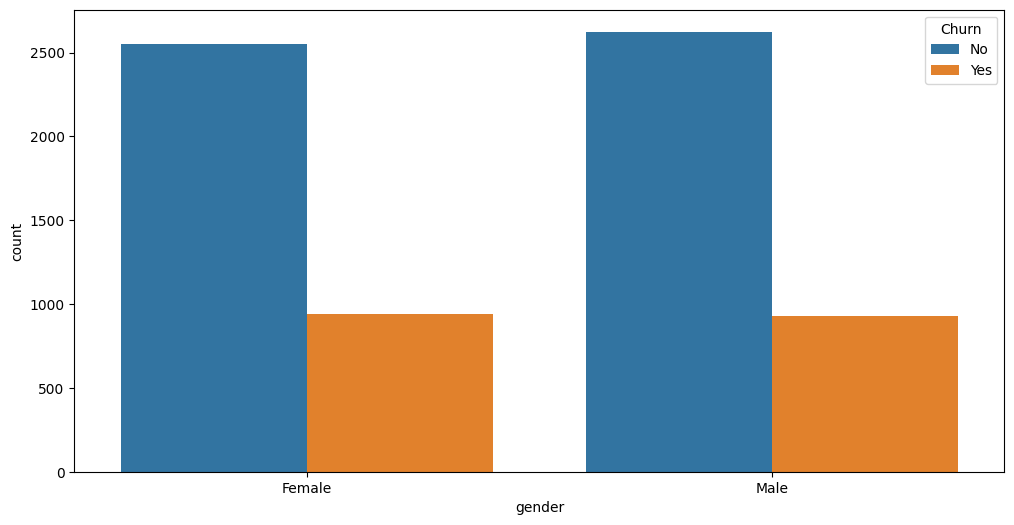

In [17]:
# Distribution of Emp_Type based on default status
plt.figure(figsize = (12,6))
sns.countplot(x = 'gender', hue = 'Churn', data = df)


In [19]:
df["TotalCharges"] = (pd.to_numeric(df["TotalCharges"],errors="coerce"))
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [21]:
df[~np.isnan(df["TotalCharges"])].shape, df.shape

((7032, 21), (7043, 21))

### None totalCharges has 0 Tenure. Removing the rows

In [22]:
df[df['tenure'] == 0].shape

(11, 21)

In [24]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)


In [25]:
df.corr().abs()

<ipython-input-25-b043812261d0>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().abs()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


#### Chek for outliers



In [26]:
numeric_cols = ['tenure', 'MonthlyCharges','TotalCharges']

In [44]:
for col in numeric_cols:
  data = df[col]
  k = 1.5
  q1, q3 = np.percentile(data, [25, 75])
  iqr = q3 - q1
  lower_bound = np.median(data) - k*iqr
  upper_bound = np.median(data) + k*iqr
  outliers = data[(data < lower_bound) | (data > upper_bound)]
  outliers_idx = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
  print(f"outliers in col {col}", len(outliers))

outliers in col tenure 0
outliers in col MonthlyCharges 0
outliers in col TotalCharges 499


In [48]:
outliers_idx["Churn"].value_counts(), outliers_idx["tenure"].value_counts()

(No     442
 Yes     57
 Name: Churn, dtype: int64,
 72    173
 71     62
 70     43
 69     32
 67     31
 66     29
 65     29
 68     28
 64     24
 63     14
 62     12
 61      9
 60      7
 59      4
 58      1
 56      1
 Name: tenure, dtype: int64)

In [50]:
outliers_idx.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
15,3655-SNQYZ,Female,0,Yes,Yes,69,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),113.25,7895.15,No
17,9959-WOFKT,Male,0,No,Yes,71,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.70,7382.25,No
30,3841-NFECX,Female,1,Yes,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95,No
35,6234-RAAPL,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),99.90,7251.70,No
57,5067-XJQFU,Male,1,Yes,Yes,66,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,108.45,7076.35,No


In [54]:
outliers_idx[["tenure", "MonthlyCharges", "TotalCharges", "Churn" ]].head(20)

,tenure,MonthlyCharges,TotalCharges,Churn
15,69,113.25,7895.15,No
17,71,106.70,7382.25,No
30,71,96.35,6766.95,No
35,72,99.90,7251.70,No
57,66,108.45,7076.35,No
59,72,107.50,7853.70,No
72,64,111.60,7099.00,No
93,65,111.05,7107.00,No
94,72,100.90,7459.05,No
104,68,110.00,7611.85,Yes


<Axes: xlabel='Churn', ylabel='tenure'>

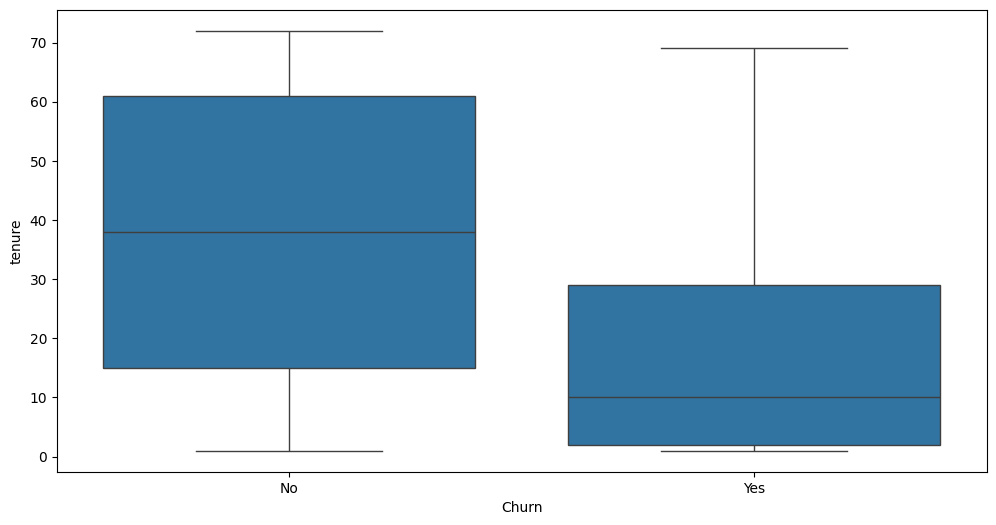

In [55]:
# Distribution of TotalCharges based on Churn value
plt.figure(figsize = (12,6))
sns.boxplot(x = 'Churn', y ='tenure', data = df, showfliers = False)

In [56]:
plots = {1 : [111], 2: [121, 122], 3: [131, 132, 133], 4: [221, 222, 223, 224], 5: [231, 232, 233, 234, 235], 6: [231, 232, 233, 234, 235, 236]}

def boxplot(x, y, df):

    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])
    plt.figure(figsize=(7*columns, 7*rows))

    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.boxplot(x=x, y=j, data=df[[x, j]], palette="Greens", linewidth=1)
        ax.set_title(j)

    return plt.show()

<ipython-input-56-f52682c1364e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=j, data=df[[x, j]], palette="Greens", linewidth=1)
<ipython-input-56-f52682c1364e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=x, y=j, data=df[[x, j]], palette="Greens", linewidth=1)


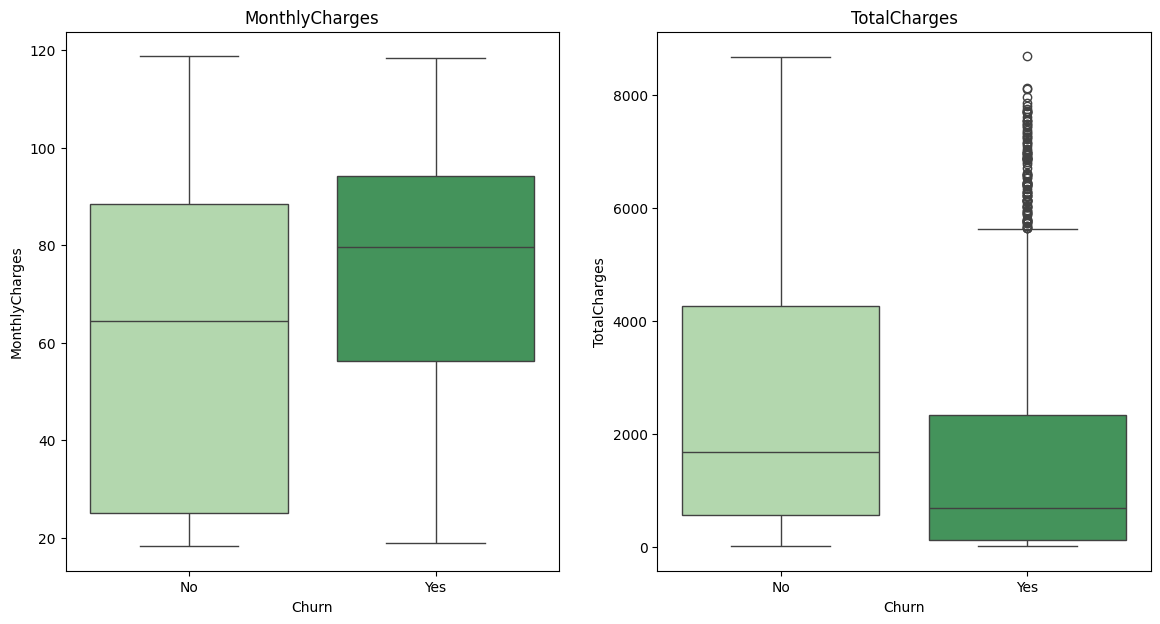

In [57]:
boxplot("Churn", ["MonthlyCharges", "TotalCharges"], df)

### TotalCharges are the result of tenure and MonthlyCharges

<!-- TotalCharges are the result of tenure and MonthlyCharges -->

In [43]:
df.shape

(7032, 21)

### Total Charges has outlier, out of 7k datapoints 500 data points are outliers
Total Charges

---




In [58]:
#Check Categorical columns
for i in df.columns[1:]:
    if df[i].dtype == "object":
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes' 'No phone service']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['No' 'Yes' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [59]:
#Replacing 'No internet service' with 'No'
cols = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]

for i in cols:
    df[i].replace("No internet service","No",inplace=True)

df["MultipleLines"].replace("No phone service","No",inplace=True)

In [60]:
for i in df.columns[1:]:
    if df[i].dtype == "object":
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['No' 'Yes']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [61]:
#Drop ID column
df.drop("customerID",axis="columns",inplace=True)

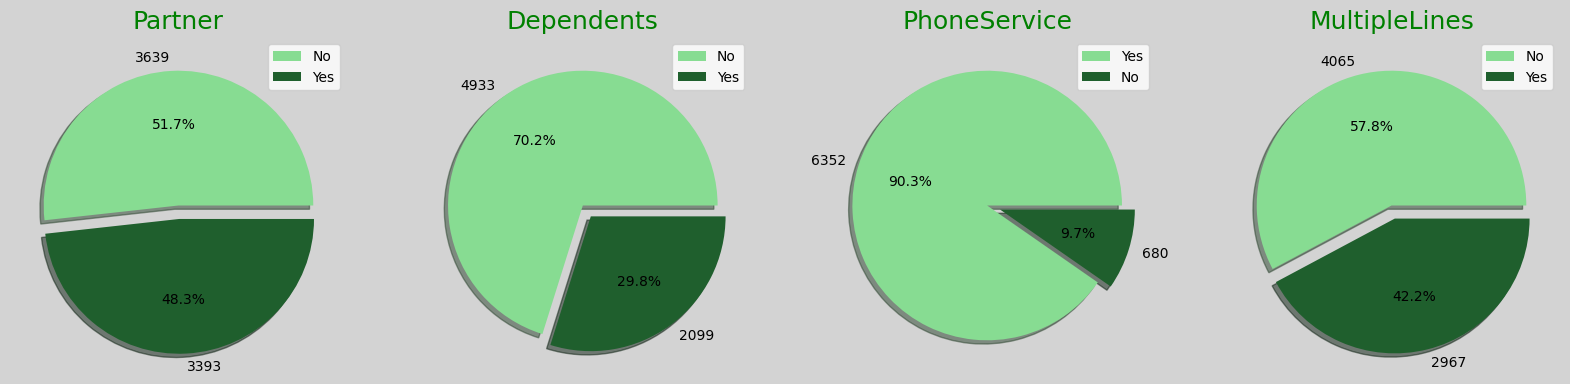

In [62]:

categ_columns = df.select_dtypes("object").columns[1:-1]

fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[:4]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%2.1f%%",
           explode=[0,0.1],shadow=True,colors=['#87DC92FF', '#1F5F2D'])
    ax.set_title(column,color="Green",size=18)
    ax.legend(data.index)

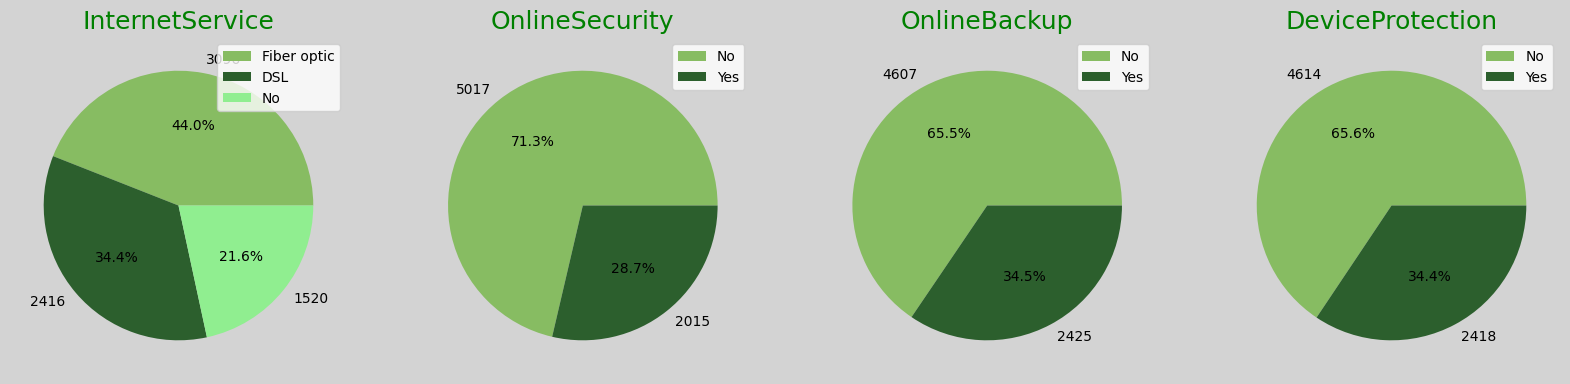

In [63]:
fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

colors = [('#87BC62FF', '#2C5F2D',"lightgreen"),('#87BC62FF', '#2C5F2D'),('#87BC62FF', '#2C5F2D'),('#87BC62FF', '#2C5F2D')]


for i, column in enumerate(categ_columns[4:8]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",
           colors=colors[i])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index,loc="best")

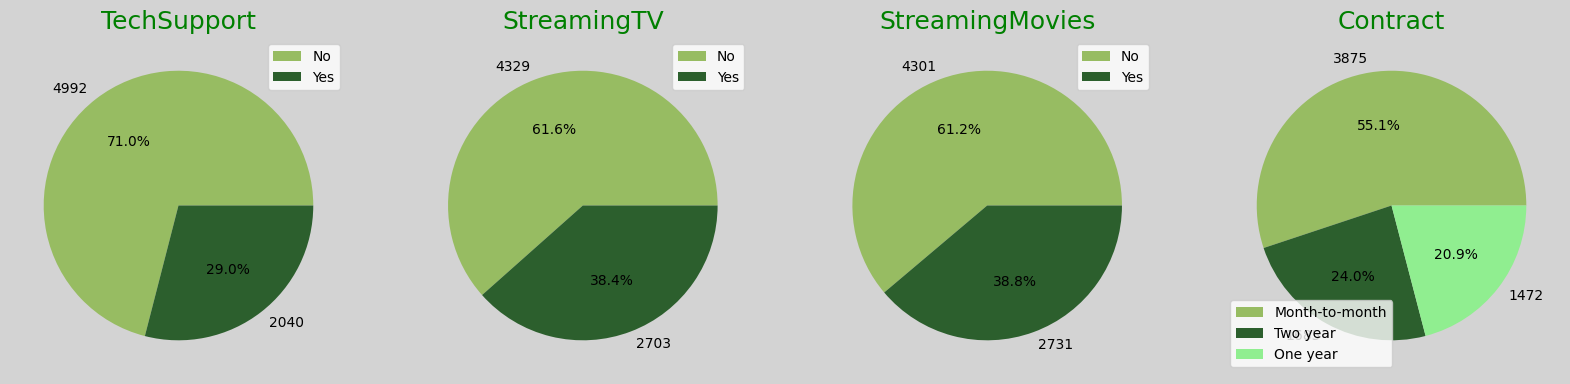

In [64]:
colors = [('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D',"lightgreen")]
fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[8:12]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",colors=colors[i])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)

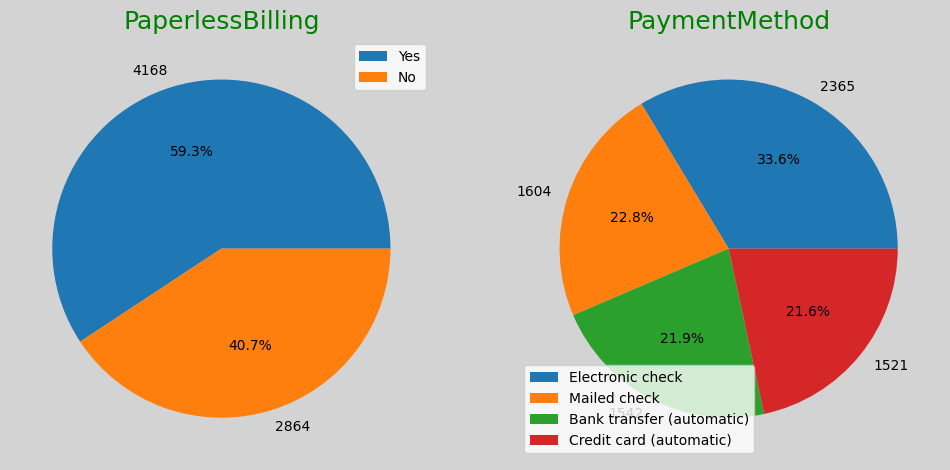

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[12:]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%")
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)

Text(0.5, 0.98, 'Distribution of TotalCharges')

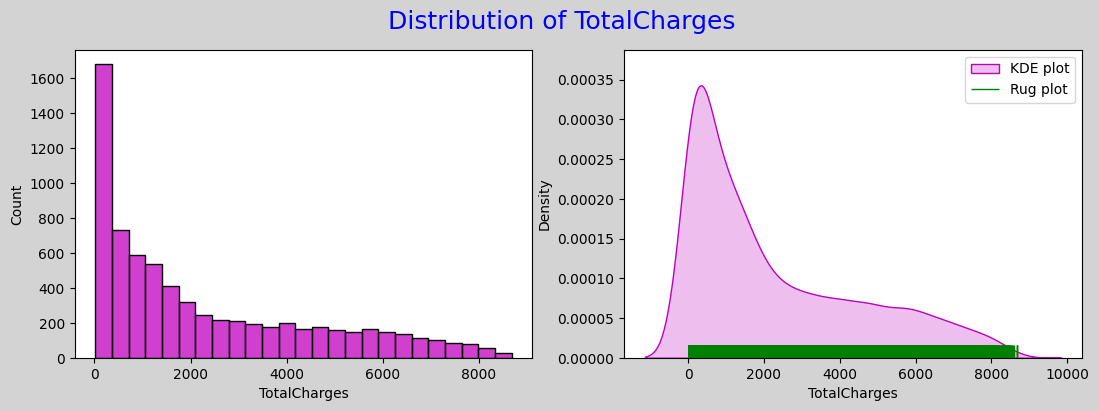

In [66]:
fig , ax = plt.subplots(1,2,figsize=(13,4),facecolor="lightgray")
sns.histplot(df["TotalCharges"],color="m",ax=ax[0])
sns.kdeplot(df["TotalCharges"],fill=True,color="m",ax=ax[1])
sns.rugplot(df["TotalCharges"],height=0.04,color="green",ax=ax[1])
ax[1].legend(["KDE plot","Rug plot"])
fig.suptitle("Distribution of TotalCharges",size=18,color="blue")

In [67]:
#Categorical Features
categorical = df.select_dtypes("object")
categorical.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [69]:
encoder = OrdinalEncoder().fit(categorical)
encoded = encoder.transform(categorical)

In [70]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [71]:
number = df.select_dtypes("number").reset_index(drop=True)
number

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65
...,...,...,...,...
7027,0,24,84.80,1990.50
7028,0,72,103.20,7362.90
7029,0,11,29.60,346.45
7030,1,4,74.40,306.60


In [72]:
cate = pd.DataFrame(encoded.astype("int64"),columns=categorical.columns).reset_index(drop=True)
df_final = pd.concat([number,cate],axis=1)
df_final.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,29.85,29.85,0,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,1,0,1,0,0,0,1,0,3,0
2,0,2,53.85,108.15,1,0,0,1,0,0,1,1,0,0,0,0,0,1,3,1
3,0,45,42.30,1840.75,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


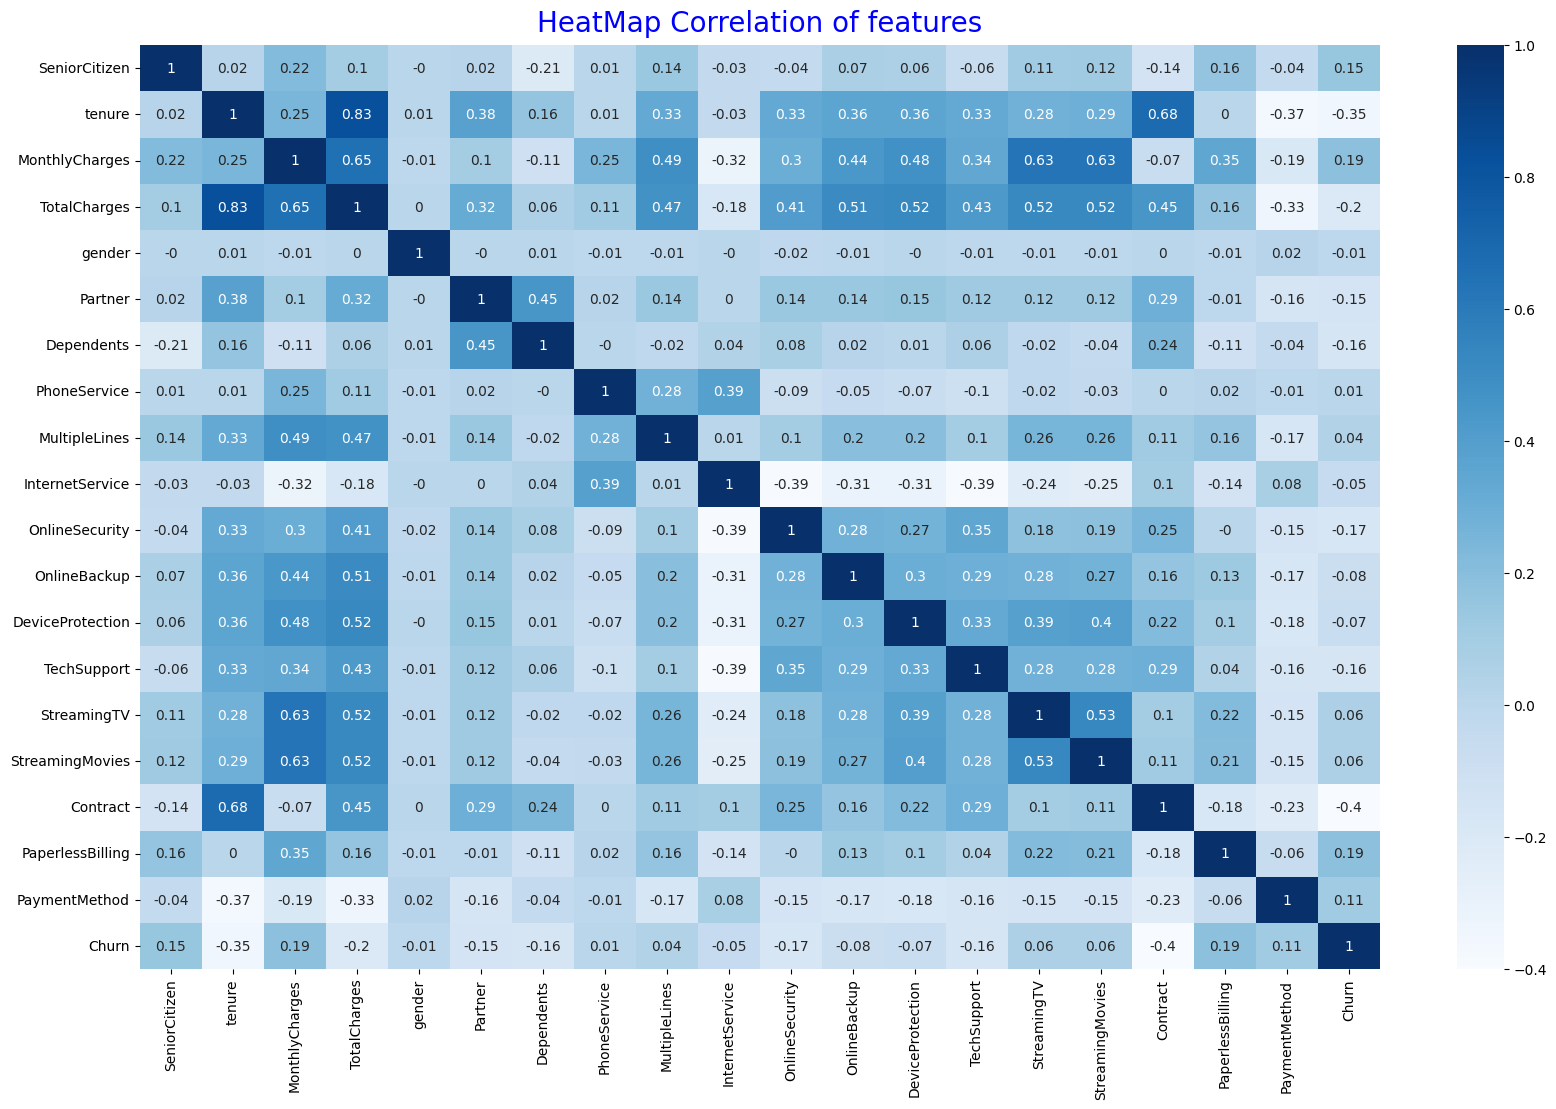

In [73]:
fig , ax = plt.subplots(figsize=(20,12))
sns.heatmap(df_final.corr().round(2),annot=True,ax=ax,cmap="Blues")
ax.set_title("HeatMap Correlation of features",size=20,color="Blue",pad=10);

### Analysis


1.   High Correlation of Tenure and Contract
2.   High Correlation of Tenure and TotalCharges
3.   High Correlation of MonthlyCharges and TotalCharges
4.   MonthlyCharges and StreamingTV



In [74]:
#Normalising Features
scaler = StandardScaler()

df_final[["tenure","MonthlyCharges","TotalCharges"]] = scaler.fit_transform(df_final[["tenure","MonthlyCharges","TotalCharges"]])

In [75]:
df_final

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,-1.280248,-1.161694,-0.994194,0,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0
1,0,0.064303,-0.260878,-0.173740,1,0,0,1,0,0,1,0,1,0,0,0,1,0,3,0
2,0,-1.239504,-0.363923,-0.959649,1,0,0,1,0,0,1,1,0,0,0,0,0,1,3,1
3,0,0.512486,-0.747850,-0.195248,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0
4,0,-1.239504,0.196178,-0.940457,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,-0.343137,0.664868,-0.129180,1,1,1,1,1,0,1,0,1,1,1,1,1,1,3,0
7028,0,1.612573,1.276493,2.241056,0,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
7029,0,-0.872808,-1.170004,-0.854514,0,1,1,0,0,0,1,0,0,0,0,0,0,1,2,0
7030,1,-1.158016,0.319168,-0.872095,1,1,0,1,1,1,0,0,0,0,0,0,0,1,3,1


In [76]:
X = df_final.drop("Churn",axis="columns")
y = df_final["Churn"]

In [77]:
smote = SMOTE(random_state=0)

X_resample, y_resample = smote.fit_resample(X,y)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_resample,y_resample,random_state=0,test_size=0.25)

In [79]:
def parameter_finder(model, parameters):

    start = time.time()

    grid = GridSearchCV(model,
                        param_grid = parameters,
                        refit = True,
                        cv = KFold(shuffle = True, random_state = 1),
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    best = grid_fit.best_estimator_
    y_pred = best.predict(X_test)

    train_score = best.score(X_train, y_train)
    test_score = best.score(X_test, y_test)
    F1_score = f1_score(y_test, y_pred).round(2)

    model_name = str(model).split('(')[0]

    end = time.time()
    takes_time = np.round(end - start,2)

    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"F1 score is {F1_score:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")


    return best,train_score, test_score, F1_score, y_pred, takes_time

In [80]:
def confusion(model,pred):
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    dis.plot()
    plt.title(str(model).split("(")[0])

In [ ]:
lr_clf = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

lr_model, train_lr, test_lr, f1_lr, pred_lr, time_lr = parameter_finder(lr_clf, param_grid)

In [82]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1277
           1       0.78      0.84      0.81      1305

    accuracy                           0.80      2582
   macro avg       0.80      0.80      0.80      2582
weighted avg       0.80      0.80      0.80      2582



In [83]:
knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9,11,13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
    }

knn_model, train_knn, test_knn, f1_knn, pred_knn, time_knn = parameter_finder(knn_clf, param_grid)

The best parameters for KNeighborsClassifier model is: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
--------------------
(R2 score) in the training set is 99.85% for KNeighborsClassifier model.
(R2 score) in the testing set is 80.95% for KNeighborsClassifier model.
F1 score is 0.83 for KNeighborsClassifier model.
--------------------
Runtime of the program is: 32.77


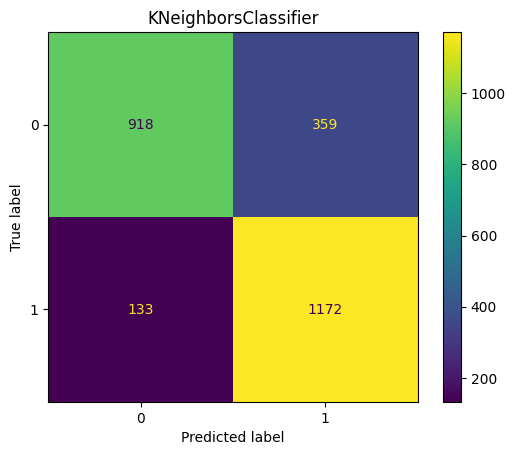

In [84]:
confusion(knn_clf,pred_knn)

In [85]:
# Given a customer profile, how likely they are likely to churn


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(50, 150, 20),
          "max_depth": [None, 3, 5, 10], #If None, then nodes are expanded until all leaves are pure
           "min_samples_split": np.arange(2, 20, 2), # The minimum number of samples required to split an internal node
           "min_samples_leaf": np.arange(1, 20, 2), # The minimum number of samples required to be at a leaf node
           "max_features": [0.2,0.5, 0.8, 1, "sqrt", "auto"], # The number of features to consider when looking for the best split:
           "max_samples": [6196]} #The sub-sample size

# Tuning our model with RandomizedSearchCV
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fitting our X_train and y_train
rs_rf.fit(X_train, y_train)

In [93]:
rs_rf.best_estimator_

RandomForestClassifier(max_depth=10, max_features=0.8, max_samples=6196,
                       min_samples_leaf=7, min_samples_split=8,
                       n_estimators=70)

In [94]:
model = RandomForestClassifier(max_depth=3, max_features=1, max_samples=6196,
                       min_samples_leaf=13, n_estimators=110)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=1, max_samples=6196,
                       min_samples_leaf=13, n_estimators=110)

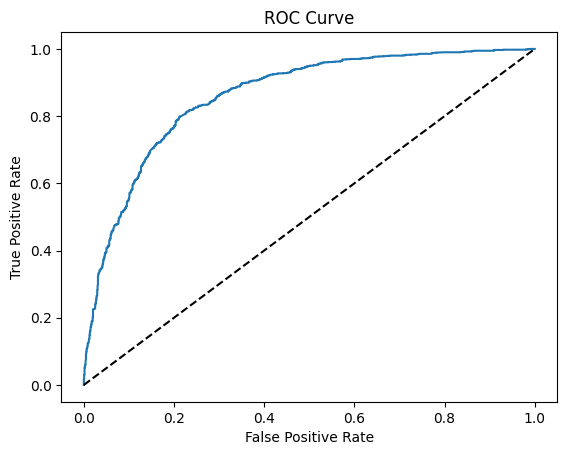

In [95]:
#ROC
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [96]:
start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.038 seconds


In [97]:
feature_names = model.feature_names_in_
importances = model.feature_importances_
std = np.std(model.feature_importances_)

important_features_dict = dict(zip(feature_names, importances))


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:5]}')

5 most important features: ['Contract', 'tenure', 'InternetService', 'Dependents', 'TotalCharges']


In [ ]:
important_features_list[:15]

In [71]:
from sklearn.metrics import classification_report

y_pred_grid = model.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1136
           1       0.85      0.76      0.80      1446

    accuracy                           0.79      2582
   macro avg       0.79      0.79      0.79      2582
weighted avg       0.80      0.79      0.79      2582



In [ ]:
1869/5174

0.36122922303826827